<a href="https://colab.research.google.com/github/AlyW8/Data-Science/blob/main/Unit6ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Exercises: Is my model good?

#### Over and Under fitting, Model Visualization, and Model/Variable Selection Concepts

These exercises are meant to get you to think about the model and variable selection process, and consider how we determine if a model is "good".

**Task1**:

Does elpd_loo mean anything if we only have one model?

- No. We need at least 2 and compare the elpd_loos of them to judge which is better.

**Task2**:

Describe overfitting, in the context of this course

- Overfitting is when the model is more complex than necessary, making it stiff and unable to adapt well to new data samples. It seems to fit the data, but it's not a great model.

**Task3**:

How do we mitigate overfitting?

- We can use weak piors, or regularizing priors, to prevent overfitting

**Task4**:

How do we mitigate underfitting?

- Underftting can be mitigated by making a more complex model that better represents the observed data set. Making a causal diagram with more predictors might help.

**Task5**:

Why would we want more than one predictor in a model?

- In the real world, there will likely be more than 1 variable affecting the thing we want to predict. Having more than 1 predictor will (ideally) better model the real-world situation and more accurately predict the estimand.

**Task6**:

Can we have too many predictors? How would we know?

- When we have too many predictors, it might lead to overfitting and the model wouldn't be a good representation of the situation.

**Task7**:

What is variable selection, and how does it work?

- Variable selection is trying to figure out which variables are necessary and helpful to include as predictors in the model, versus which ones aren't necessary and don't contribute much. First, a causal diagram is created with variables that could be useful. Then, create models that have varying predictors and compare them using elpd_loo to figure out which predictors should be included in the final model.

**Task8**:

Describe the differences and similarities between the following three models: linear regression with two predictors, one of which is a categorical variable:

- adding the variables in the model, as is standard.
- using that categorical variable as a hierarchy upon the other predictor variable.
- adding the variables, plus the categorical variable's interaction with the other variable.



---


- In the 1st, FT and Pos both affect FG, but independently of each other. The 2 variables have no affect on each other. In the 2nd, Pos affects FT as well as FG. In the 3rd, Pos and FT both afect each other, as well as FG.
- In the 2nd, the categorical variable's effect on the other variable is modeled as well. In the 1st, the categorical variable's effect on the other variable isn't modeled. In the 2nd, the FT%|Pos, which affects mu, is being determined by two more distributions for sd and mean. There's also a 1|Pos that affects the mu. In the 3rd, we don't have hyperpriors, but we have 4 variables affecting mu (FT, Intercept, Pos, FT:Pos)
- mu is the estimated line that predicts FG based on the variables.

**Task9**:

How do we visualize multiple linear regression models? Can we visualize the entire model, all at once?

- We can visualie them with graphs, up to dimensions that we can understand, but when we add enough variables we really can't visualize them.

**Task10**:

Compare the following linear models that all use the basketball data to predict field goal percentage:

- predictors free throw percentage and position (with position as a categorical predictor)
- predictors free throw percentage and position (with position as a hierarchy)
- predictors free throw percentage and position (with position interacting with frew throw percentage)
- predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
- predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

using ```az.compare()``` and ```az.plot_compare()```, or an equivalent method using LOO (elpd_loo).

In [3]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install bambi

In [5]:
import bambi as bmb

You may use the following two code blocks to load and clean the data.

In [ ]:
#have to drop incomplete rows, so that bambi will run
bb = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
    ).dropna()

In [ ]:
#only look at players who played more than 600 minutes
#which is 20 min per game, for 30 games
bb = bb.query('MP > 600')
#remove players who never missed a free throw
bb = bb.query('`FT%` != 1.0')
#filter out the combo positions. This will make it easier to read the graphs
bb = bb.query("Pos in ['C','PF','SF','SG','PG']")
#gets rid of the annoying '%' sign
bb.rename(columns={"FT%":"FTp","FG%":"FGp"}, inplace=True)

In [ ]:
bb

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FGp,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
5,Grayson Allen,SG,28,PHO,75,74,2513,340,682,0.499,...,48,247,295,227,69,45,95,157,1014,allengr01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,Jalen Wilson,PF,23,BRK,43,3,664,76,179,0.425,...,47,84,131,45,11,4,19,48,214,wilsoja03
563,James Wiseman,C,22,DET,63,6,1091,187,305,0.613,...,110,226,336,54,12,39,66,141,446,wisemja01
565,Christian Wood,PF,28,LAL,50,1,872,123,264,0.466,...,39,215,254,49,16,33,50,72,347,woodch01
566,Delon Wright,PG,31,TOT,47,1,742,74,188,0.394,...,19,67,86,119,54,11,14,32,210,wrighde01


In [ ]:
model_bb_1 = bmb.Model("`FGp` ~ `FTp` + Pos", bb)
idata_bb_1 = model_bb_1.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_bb_2 = bmb.Model("FGp ~ (FTp|Pos)", data=bb)
idata_bb_2 = model_bb_2.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_bb_3 = bmb.Model("FGp ~ FTp + Pos + FTp:Pos", bb)
idata_bb_3 = model_bb_3.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_bb_4 = bmb.Model("FGp ~ FTp + Pos + '3PA' + FTp:Pos + FTp:'3PA' + Pos:'3PA'", data = bb)
idata_bb_4 = model_bb_4.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_bb_5 = bmb.Model("FGp ~ FTp + Pos + '3PA' + '3PA':Pos", bb)
idata_bb_5 = model_bb_5.fit(idata_kwargs={"log_likelihood":True})

Output()

In [ ]:
p_df_bmb_2 = az.compare( {"bb_1":idata_bb_1,"bb_2":idata_bb_2,"bb_3":idata_bb_3,"bb_4":idata_bb_4,"bb_5":idata_bb_5} )
p_df_bmb_2

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
bb_5,0,530.020252,12.553540,0.000000,6.138240e-01,15.849186,0.000000,False,log
bb_4,1,528.635118,19.534391,1.385133,3.861760e-01,14.955252,3.806765,False,log
bb_3,2,508.917057,14.273330,21.103195,0.000000e+00,16.848339,7.690113,False,log
bb_2,3,508.219691,13.891669,21.800561,0.000000e+00,17.020525,7.167082,False,log
bb_1,4,507.492222,8.166309,22.528030,1.332268e-15,16.021226,6.865959,False,log


**Task11**:

Which model is "better" according to this metric?

Why do you think that is?

- According to elpd_loo, the 5th model, where we predict FG% with FT%, Pos, and 3PA but with only interactions between 3PA and Pos, is the best. The 5th and 4th, with more variables, are better than the first 3. This could be because 3PA is a rather important influence on FG%, which makes models 4 and 5 better. It seems 3PA and Pos aren't really affected by or affect FT%, which makes the 5ht model better, but I don't really know why that is.

**Task12:**

The body data set has a measure of body fat percentage (siri), as well as several other measurments of other parts of a person's body, plus their age.

Create a sensible causal diagram for this set of variables.

Based on your causal diagram, which variable should you try to predict? Why?

- I'd probably try to predict weight, since it has a clear relationship with wrist, abdomen, and thigh. Abdomen and thigh also seem to have a relationship.

In [6]:
body = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/body_fat.csv')

In [7]:
body.head()

,siri,age,weight,height,abdomen,thigh,wrist
0,12.3,23,70.1,172,85.2,59.0,17.1
1,6.1,22,78.8,184,83.0,58.7,18.2
2,25.3,22,70.0,168,87.9,59.6,16.6
3,10.4,26,84.0,184,86.4,60.1,18.2
4,28.7,24,83.8,181,100.0,63.2,17.7


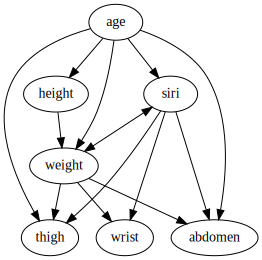

In [ ]:
dag_body = gv.Digraph()

dag_body.node('Y','age')
dag_body.node('S','siri')
dag_body.node('W','weight')
dag_body.node('H','height')
dag_body.node('T','thigh')
dag_body.node('A','abdomen')
dag_body.node('R','wrist')

dag_body.edges(['YW','YH','YA','YT','YS','ST','SA','SR','WT','WA','HW','WR'])
dag_body.edge('S','W', dir='both')

dag_body

In [ ]:
sns.pairplot(body)